In [12]:
import sys
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import pysubgroup as ps
sys.setrecursionlimit(3000)
import pickle
from SDDeclinations import *
from SGDiscovery import *
from SDPostprocessing import *
from DynamicThreshold import *
from scipy.stats import expon, gamma
import math

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%sns.set(color_codes=True)
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]

UsageError: Line magic function `%sns.set(color_codes=True)` not found.


In [3]:
import warnings
warnings.filterwarnings("ignore")
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [4]:
threshold = 10000
requetes = pd.read_csv('requetes_sd_jf.csv', index_col=[0])

In [5]:
requetes['durationMSDecales'] = requetes['durationMS'] - 5000

In [6]:
cond = requetes['durationMSDecales'] < 100000
cond2 = requetes['nbLignes'] < 100000

### EXECUTION TIME

#### Real distribution

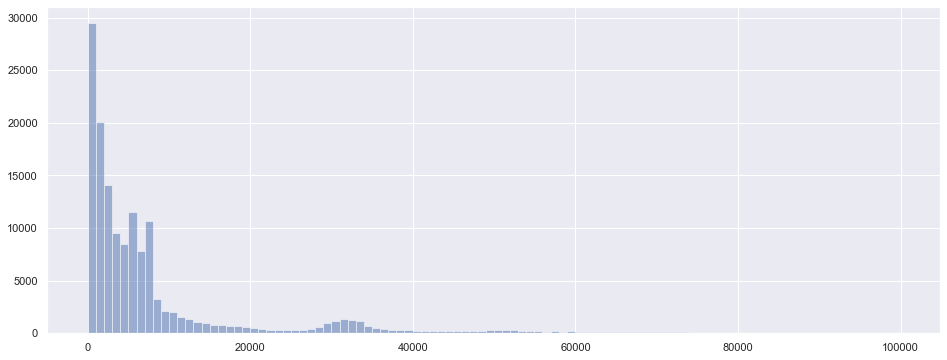

In [7]:
plt.hist(requetes[cond]['durationMSDecales'], 100, alpha=0.5, density = False)
plt.show()

#### Simulated distribution

<AxesSubplot:>

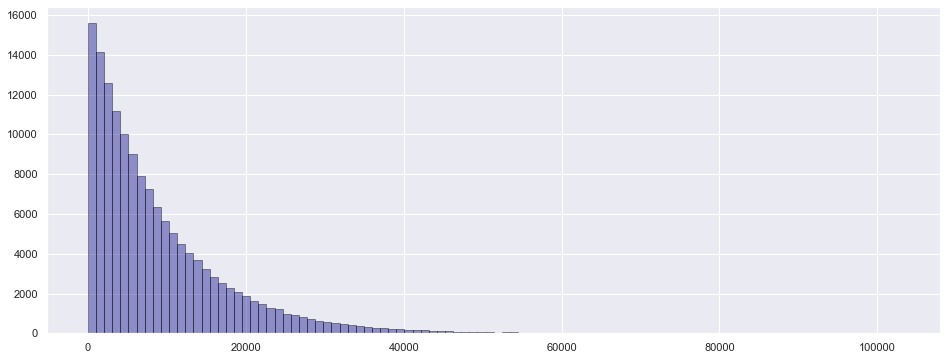

In [8]:
'Loi exponentielle avec lambda = 1 / moyenne'
durations = expon.rvs(scale=requetes[cond]['durationMSDecales'].mean(),loc=0,size=requetes[cond].shape[0])
sns.distplot(durations,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<AxesSubplot:>

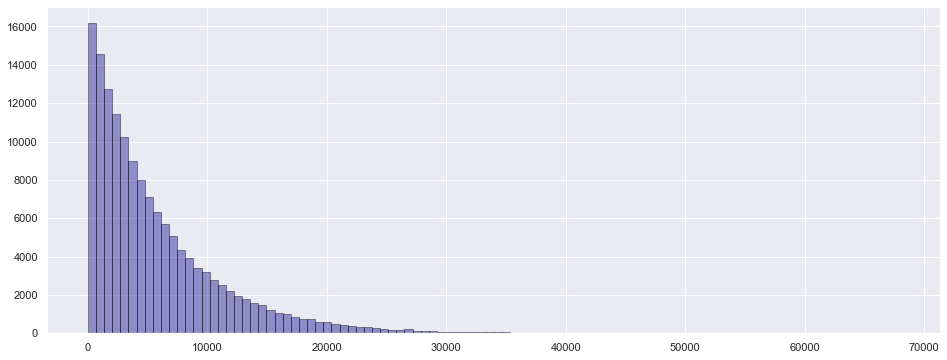

In [9]:
'Loi exponentielle avec lambda = ln(2) / mediane'
durations = expon.rvs(scale=requetes[cond]['durationMSDecales'].median() / math.log(2),loc=0,size=requetes[cond].shape[0])
sns.distplot(durations,kde=False,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
def get_threshold_duration (requetes, pvalue) :
    
    requetes['durationMSDecales'] = requetes['durationMS'] - 5000
    expo = expon(scale=requetes['durationMSDecales'].mean(),loc=0)
    for i in np.arange(0,100000,100):
        if expo.cdf(i) < pvalue and expo.cdf(i+100) > pvalue :
            break
    print(i + 100 + 5000)

In [13]:
get_threshold_duration (requetes, 0.65)

19800


In [ ]:
def get_dynamic_target_duration (requetes, pvalue) :
    
    requetes['durationMSDecales'] = requetes['durationMS'] - 5000
    expo = expon(scale=requetes['durationMSDecales'].mean(),loc=0)
    requetes['pvalue_duration'] = requetes['durationMSDecales'].apply(lambda x : expo.cdf(x))
    requetes['class_duration'] = requetes ['pvalue_duration'].apply(lambda x : discretize_duration(x,pvalue))

In [14]:
get_dynamic_target_duration (requetes, 0.65)

In [15]:
requetes['class_duration'].value_counts()

False    123912
True      24884
Name: class_duration, dtype: int64

###  EXECUTION TIME with #LINES

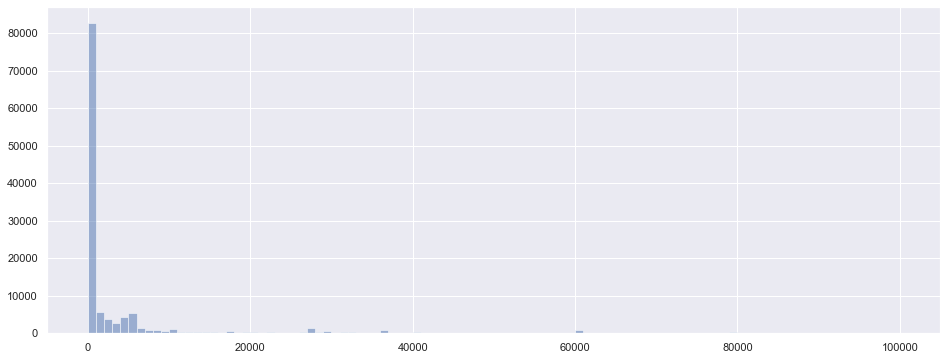

In [16]:
plt.hist(requetes[cond2]['nbLignes'], 100, alpha=0.5, density=False)
plt.show()

<AxesSubplot:>

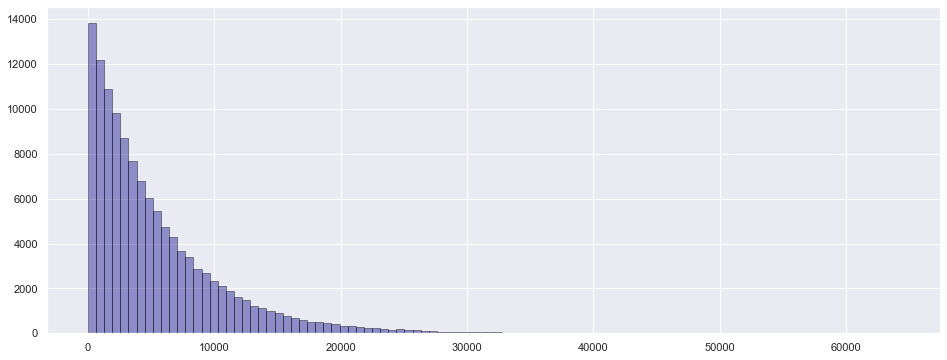

In [17]:
'Loi exponentielle avec lambda = 1 / moyenne'
nbLignes = expon.rvs(scale=requetes[cond2]['nbLignes'].mean(),loc=0,size=requetes[cond2].shape[0])
sns.distplot(nbLignes,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<AxesSubplot:>

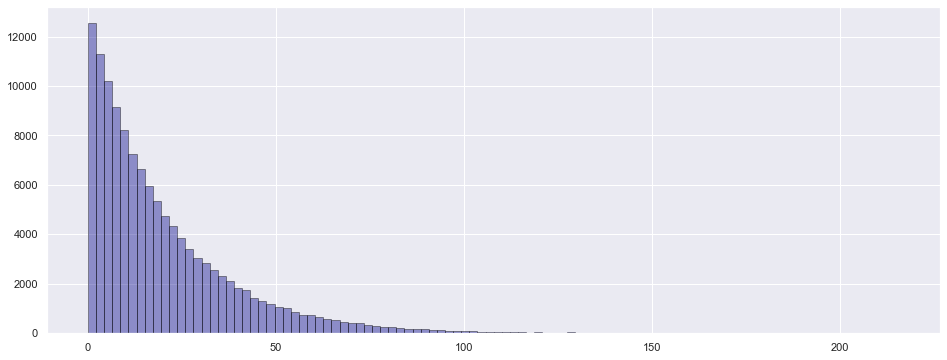

In [19]:
'Loi exponentielle avec lambda = ln(2) / mediane'
nbLignes = expon.rvs(scale=requetes[cond2]['nbLignes'].median() / math.log(2),loc=0,size=requetes[cond2].shape[0])
sns.distplot(nbLignes,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [20]:
expo_nbLignes = expon(scale=requetes[cond2]['nbLignes'].mean(),loc=0)
expo_nbLignes.cdf(1000)

0.16808197805478609

In [21]:
(requetes[cond2]['nbLignes'] < 1000).value_counts()

True     82841
False    41109
Name: nbLignes, dtype: int64

In [22]:
82841 / (41109 + 82841)

0.6683420734167003

In [23]:
'Loi gamma de parametres K et THETA'

'Estimateurs'
esp = requetes[cond2]['durationMS'].mean() # esp = k * theta
var = requetes[cond2]['durationMS'].var() # var = k * (theta)**2
theta = var / esp
k = esp / theta

print('K =',k)
print('THETA =',theta)

K = 0.024632307722794594
THETA = 720535.8974943236


<AxesSubplot:>

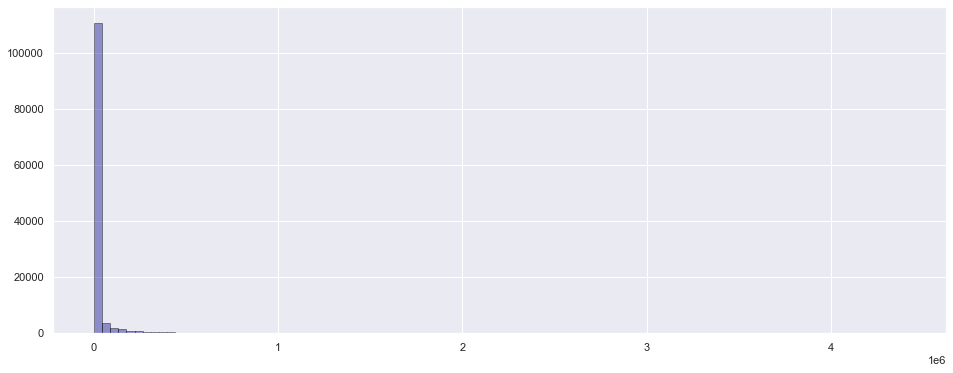

In [24]:
nbLignes = gamma.rvs(a = k*2, scale=theta,loc=0,size=requetes[cond2].shape[0])
sns.distplot(nbLignes,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [25]:
gamma_nbLignes = gamma(a = 0.06, scale=theta,loc=0)
gamma_nbLignes.cdf(100)

0.6057987633913803

In [26]:
(requetes[cond2]['nbLignes'] <= 100).value_counts()

True     71520
False    52430
Name: nbLignes, dtype: int64

In [27]:
71520 / (71520 + 52430)

0.5770068576038725

### Independance between the two distributions 

In [28]:
requetes[['durationMS','nbLignes']].corr()

,durationMS,nbLignes
durationMS,1.000000,0.073258
nbLignes,0.073258,1.000000


### Product of the two CDF

In [29]:
'P(duration <= T) * (1- P(nbLignes <= N))'

gamma_nbLignes = gamma(a = 0.06, scale=theta,loc=0)
requetes['pvalue_nbLignes'] = requetes['nbLignes'].apply(lambda x : 1 - gamma_nbLignes.cdf(x))

In [30]:
requetes['product_pvalue'] = requetes['pvalue_duration'] * requetes['pvalue_nbLignes']

In [31]:
requetes[['durationMS','pvalue_duration','nbLignes','pvalue_nbLignes','product_pvalue']].sort_values(by='product_pvalue', 
                                                                                                     ascending=False).head(10)

,durationMS,pvalue_duration,nbLignes,pvalue_nbLignes,product_pvalue
18338,1648718.0,1.0,0.0,1.0,1.0
16405,571249.0,1.0,0.0,1.0,1.0
123660,817805.0,1.0,0.0,1.0,1.0
40591,1151024.0,1.0,0.0,1.0,1.0
32658,890854.0,1.0,0.0,1.0,1.0
32532,1266308.0,1.0,0.0,1.0,1.0
32530,1286425.0,1.0,0.0,1.0,1.0
32230,815885.0,1.0,0.0,1.0,1.0
114109,2692543.0,1.0,0.0,1.0,1.0
123931,1013319.0,1.0,0.0,1.0,1.0


#### Real distribution of product of P-values

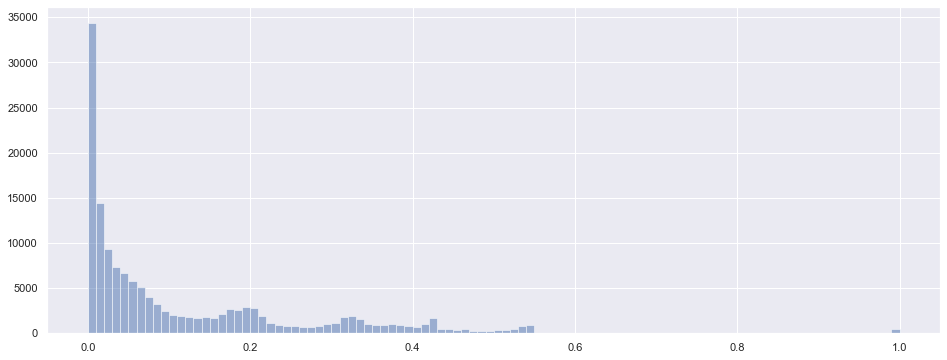

In [32]:
plt.hist(requetes['product_pvalue'], 100, alpha=0.5, density = False)
plt.show()

#### Simulated Distribution 

<AxesSubplot:>

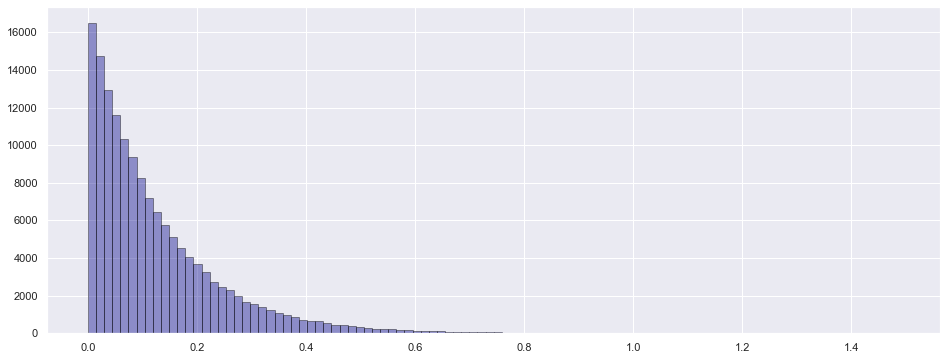

In [33]:
'Loi exponentielle avec lambda = 1 / moyenne'
product_pvalues = expon.rvs(scale=requetes['product_pvalue'].mean(),loc=0,size=requetes.shape[0])
sns.distplot(product_pvalues,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<AxesSubplot:>

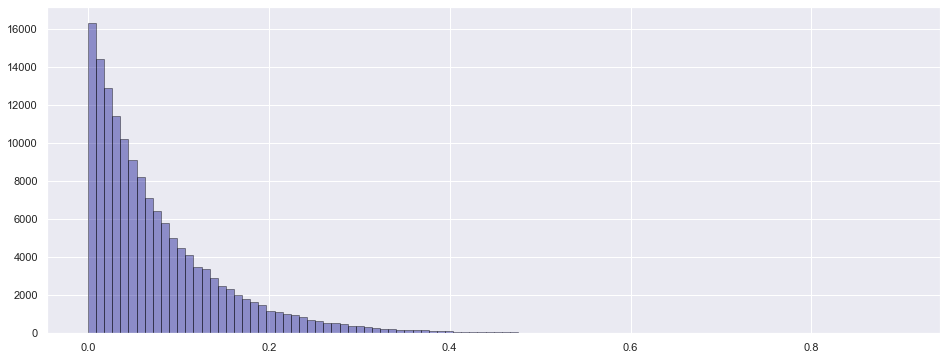

In [34]:
'Loi exponentielle avec lambda = ln(2) / mediane'
product_pvalues = expon.rvs(scale=requetes['product_pvalue'].median() / math.log(2),loc=0,size=requetes.shape[0])
sns.distplot(product_pvalues,kde= False ,hist = True,
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [35]:
'Loi gamma de parametres K et THETA'

'Estimateurs'
esp = requetes['product_pvalue'].mean() # esp = k * theta
var = requetes['product_pvalue'].var() # var = k * (theta)**2
theta = var / esp
k = esp / theta

print('K =',k)
print('THETA =',theta)

K = 0.6044467906925651
THETA = 0.20817149645608257


<AxesSubplot:>

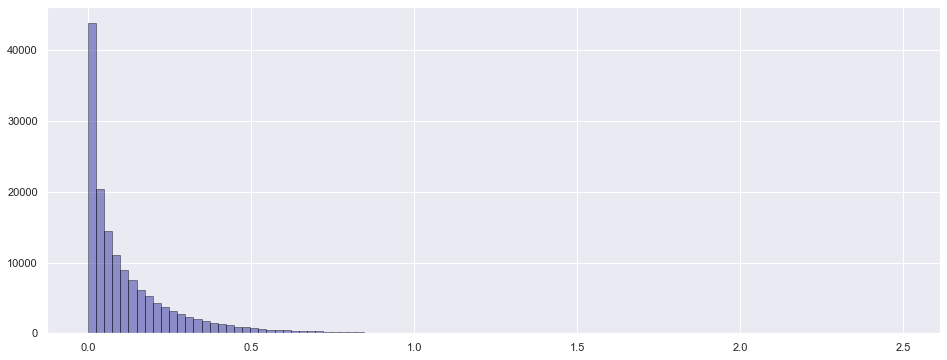

In [36]:
product_pvalues = gamma.rvs(a = k, scale = theta, loc = 0,size = requetes.shape[0])
sns.distplot(product_pvalues,kde = False ,hist = True,
             bins = 100, color = 'darkblue', 
             hist_kws = {'edgecolor':'black'},
             kde_kws = {'linewidth': 4})

In [37]:
gamma_product_pvalues = gamma(a = k, scale = theta, loc = 0)
gamma_product_pvalues.cdf(0.12)

0.6547076356840222

In [38]:
def get_dynamic_target_class(requetes, pvalue) :
    
    # pvalues duration MS
    requetes['durationMSDecales'] = requetes['durationMS'] - 5000
    expo = expon(scale=requetes['durationMSDecales'].mean(),loc=0)
    requetes['pvalue_duration'] = requetes['durationMSDecales'].apply(lambda x : expo.cdf(x))
    
    # pvalues nbLignes
    esp_nbLignes = requetes[cond2]['durationMS'].mean() # esp = k * theta
    var_nbLignes = requetes[cond2]['durationMS'].var() # var = k * (theta)**2
    theta_nbLignes = var_nbLignes / esp_nbLignes
    k_nbLignes = esp_nbLignes / theta_nbLignes
    gamma_nbLignes = gamma(a = k_nbLignes*2, scale=theta_nbLignes,loc=0)
    requetes['pvalue_nbLignes'] = requetes['nbLignes'].apply(lambda x : 1 - gamma_nbLignes.cdf(x))
    
    # product pvalues 
    requetes['product_pvalue'] = requetes['pvalue_duration'] * requetes['pvalue_nbLignes']
    
    #pvalues of product of pvalues
    esp_pvalues = requetes['product_pvalue'].mean() # esp = k * theta
    var_pvalues = requetes['product_pvalue'].var() # var = k * (theta)**2
    theta_pvalues = var_pvalues / esp_pvalues
    k_pvalues = esp_pvalues / theta_pvalues
    gamma_product_pvalues = gamma(a = k_pvalues, scale = theta_pvalues, loc = 0)
    requetes['pvalue_pvalues'] = requetes['product_pvalue'].apply(lambda x : gamma_product_pvalues.cdf(x))
    requetes['class'] = requetes['pvalue_pvalues'].apply(lambda x : discretize_duration(x,pvalue))

In [39]:
get_dynamic_target_class(requetes, 0.65)

In [40]:
requetes['class'].value_counts()

False    97152
True     51644
Name: class, dtype: int64

In [41]:
51644 / (97152 + 51644)

0.3470792225597462

application


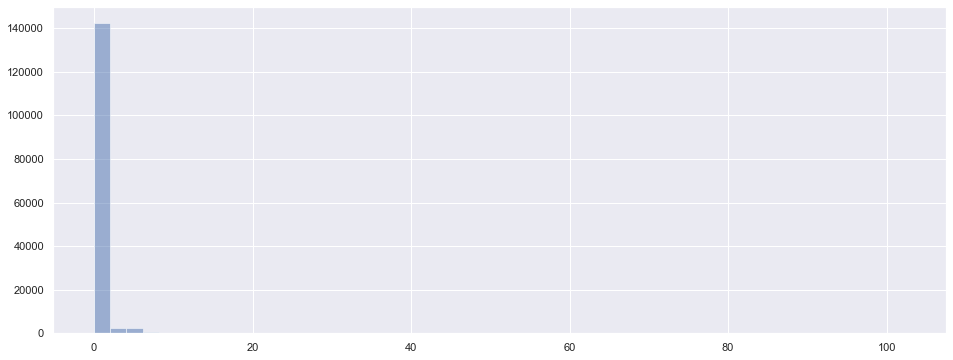

commit


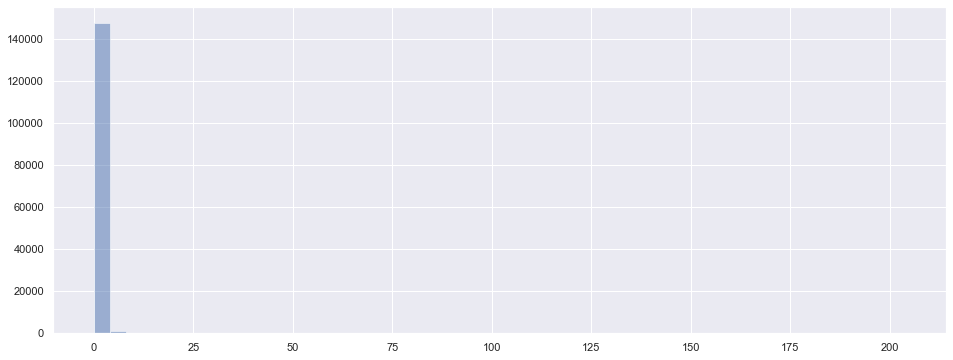

concurrence


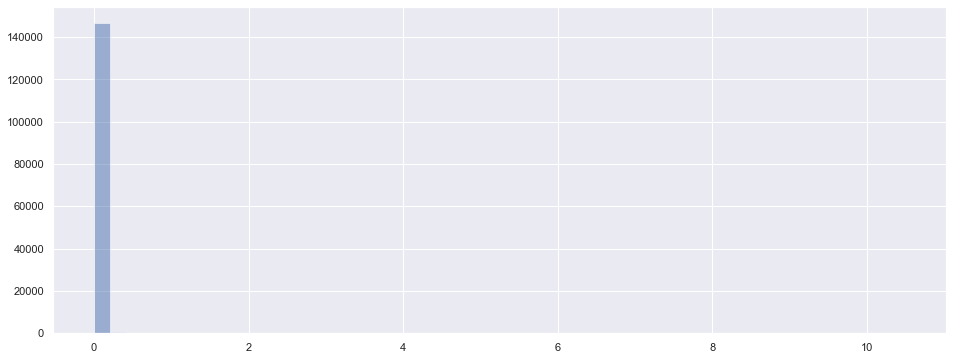

configuration


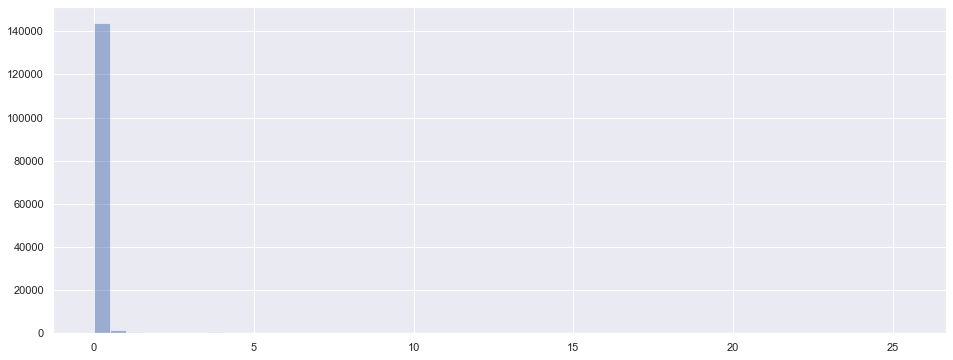

cpu


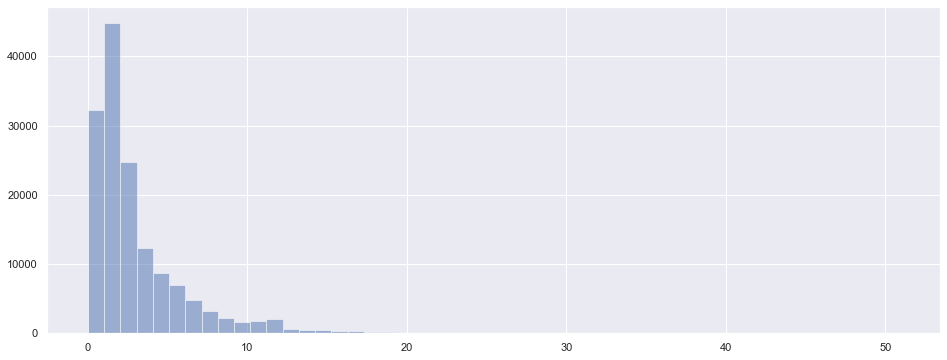

network


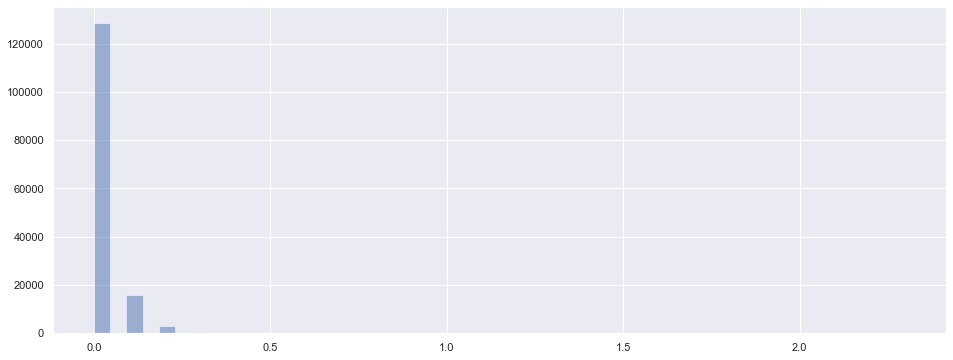

autre


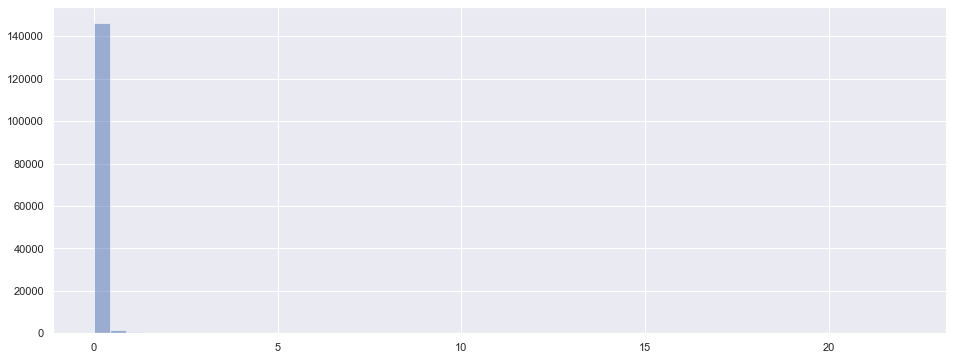

systemI/O


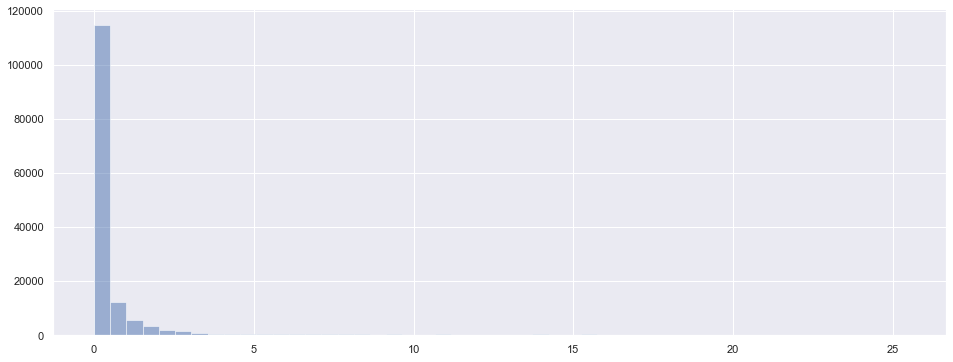

userI/O


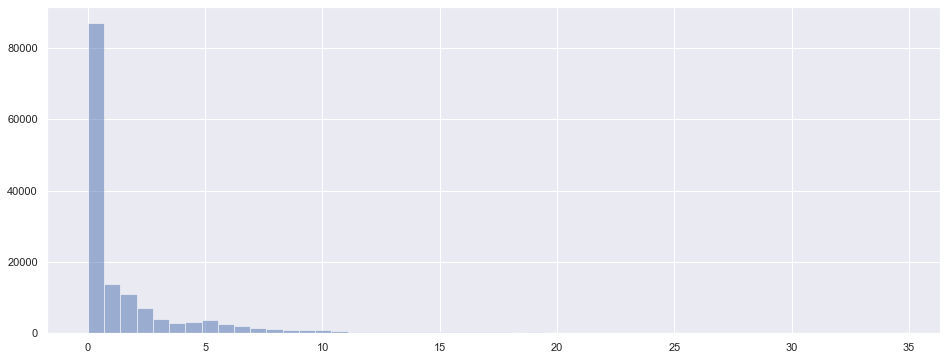

administrative


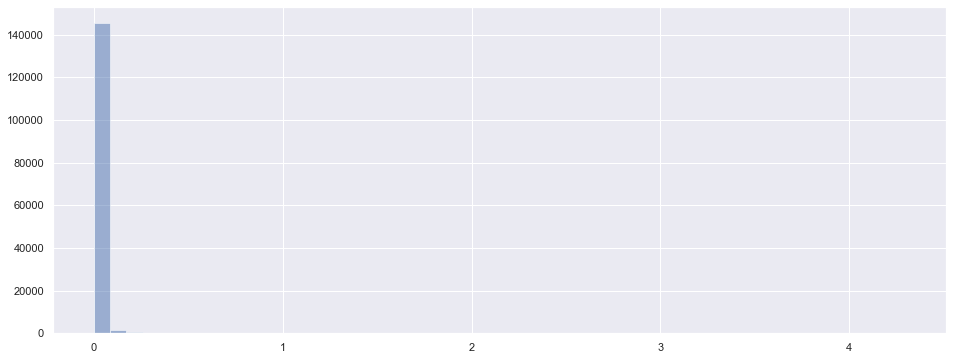

schuduler


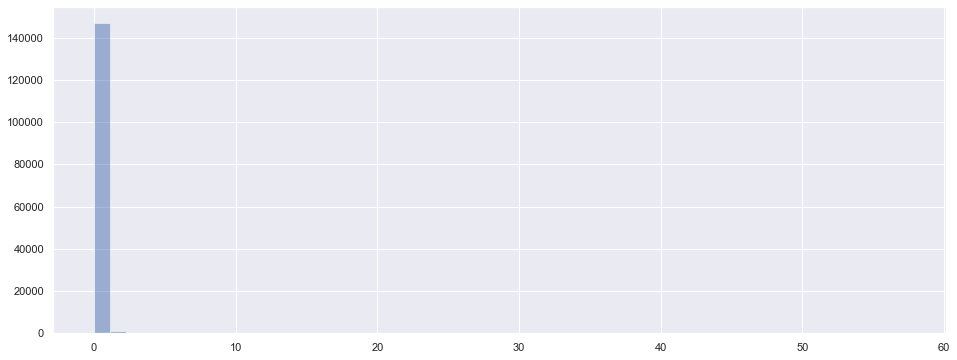

queueing


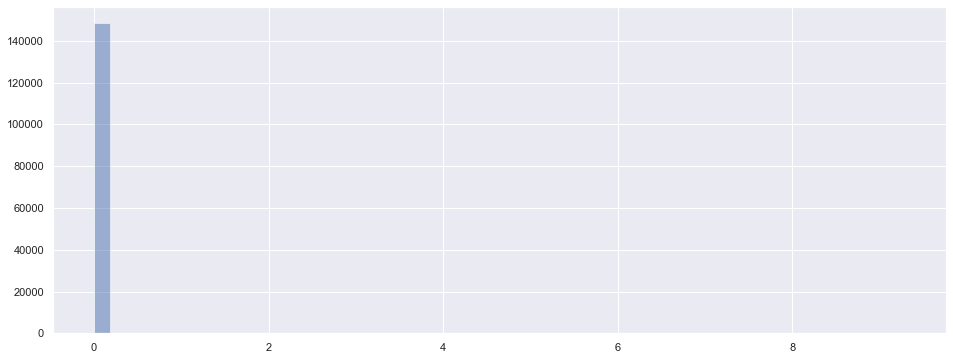

In [10]:
for column in requetes.columns[23:35] :
    print(column)
    plt.hist(requetes[column], 50, alpha=0.5, density=False)
    plt.show()

In [45]:
requetes[requetes['requete'].str.contains('mng_batch.noinstance')]

,day,hour,requete,nbLignes,long,durationMS,instanceCode,nbUtilisateurs,DeclinaisonCOP,versionMajCode,...,GROUPBY_fr.infologic.stocks.gestion.modele.mvtprevision.signe,GROUPBY_fr.infologic.global.outils.modele.menuitemsstatistique.code,GROUPBY_fr.infologic.comptabilite.ecriture.modele.mvt.typcompte,durationMSDecales,pvalue_duration,class_duration,pvalue_nbLignes,product_pvalue,pvalue_pvalues,class
